# Import

In [1]:
train_models = True

In [110]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
# from matplotlib import animation
# from JSAnimation.IPython_display import display_animation
# import gym
import scipy.stats as stats
from collections import namedtuple
import statistics
import time
import os
%matplotlib inline

import tensorflow as tf
from tensorflow.python.keras.models import clone_model, load_model, Model
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Input, concatenate
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.initializers import Zeros, Ones, Constant, he_normal, truncated_normal
from tensorflow.python.keras import backend

from util.black_scholes_helper import call_option
from util.path_generator import geometric_brownian_generator, wiener_process_generator

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Brains, Agents, Environments, and Trainers

## Brains

In [3]:
Transition = namedtuple( 'Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.index = 0
    
    def push(self, state, action, state_next, reward):
        
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.index] = Transition(state, action, state_next, reward)
        self.index = (self.index + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class BrainDelta:
    
    def __init__(self, num_states, num_actions, is_rounded = True):
        self.num_states = num_states
        self.num_actions = num_actions
        self.is_rounded = is_rounded
    
    def replay(self):
        return
    
    def decide_action(self, state, episode=None):
        if self.is_rounded:
            return np.round(state[3])
        else:
            return state[3]

In [5]:
class BrainDQN:
    
    def __init__(self, num_states, num_actions):
        
        self.num_states = num_states
        self.num_actions = num_actions
        self.freq_update_target = FREQ_UPDATE_TARGET
        self.count_replay = 0
        self.memory = ReplayMemory(CAPACITY)
        
        # Construct a neural network
        input_dim = self.num_states
        output_dim = self.num_actions
        hidden_layers = [16, 16,]
        activation_func = 'relu'
        k_init = he_normal(seed=0)
        optimizer = Adam(lr=0.001)
        
        self.model = Sequential()
        for i, fan_in in enumerate( ([input_dim,]+hidden_layers)[:-1] ):
            fan_out = hidden_layers[i]
            self.model.add(Dense(input_dim=fan_in, units=fan_out, kernel_initializer=k_init))
            # self.model.add(BatchNormalization())
            self.model.add(Activation(activation_func))
        self.model.add(Dense(units=output_dim, kernel_initializer=truncated_normal(seed=0)))
        
        # print(self.model)
        
        # Set how to train the model
        self.model.compile(loss='mse', optimizer=optimizer,)
        self._target_model = clone_model(self.model)
    
    def save(self, file_name):
        self.model.save(file_name)
    
    def load(self, file_name):
        self.model = load_model(file_name)
        self._target_model = clone_model(self.model)
    
    def replay(self):
        
        if len(self.memory) < BATCH_SIZE: return
        
        # Make mini batch
        transitions = self.memory.sample(BATCH_SIZE)
        transitions = list(zip(*transitions))
        
        states = np.array(transitions[0])
        actions = np.array(transitions[1])
        n_states = np.array(transitions[2])
        rewards = np.array(transitions[3])
        
        X = np.zeros_like(states)
        for i, n_s in enumerate(n_states): 
            if n_s is not None:
                X[i, :] = n_s
            else:
                X[i, :] = states[i, :]
        n_q = np.max(self._target_model.predict(X), axis=1)
        
        # Make targets for regression
        q = self.model.predict(states)
        for i, n_s in enumerate(n_states): 
            r = rewards[i]
            a = actions[i]
            if n_s is not None:
                r += GAMMA*n_q[i]
            q[i,a] = r
        
        # Update weight parameters
        loss = self.model.train_on_batch(states, q)
        
        self.count_replay += 1
        if self.count_replay % self.freq_update_target == 0:
            self.update_target_model()
    
    def decide_action(self, state, episode=None):
        
        if episode is not None:
            epsilon = 0.5 * (1 / (episode + 1))
        else:
            epsilon = 0
        
        p = np.random.uniform(0,1)
        if p >= epsilon:
            state = np.array(state).reshape(1,-1)
            action = np.argmax(self.model.predict(state)[0])
        else:
            action = np.random.randint(0, self.num_actions)
        
        return action
    
    def update_target_model(self):
        self._target_model.set_weights(self.model.get_weights())

In [6]:
# This class is implemented referring to the below:
# https://github.com/germain-hug/Deep-RL-Keras/tree/master/DDPG
class Actor:
    
    def __init__(self, env_dim, act_dim, act_range, lr, tau):
        self.env_dim = env_dim
        self.act_dim = act_dim
        self.act_range = act_range
        self.tau = tau
        self.lr = lr
        
        # Make models and optimizer
        self.model = self.network()
        self.target_model = self.network()
        self.my_optimizer = self.optimizer()
    
    def network(self):
        inp = Input(shape=(self.env_dim,))
        x = Dense(12, activation='relu', kernel_initializer=he_normal(seed=0))(inp)
        x = Dense(12, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        x = Dense(12, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        out = Dense(self.act_dim, activation='linear', kernel_initializer=truncated_normal(seed=0))(x)
        return Model(inp, out)
    
    def make_action(self, state):
        # the input is a state vector [shape = (self.env_dim,)]
        action = self.model.predict(np.expand_dims(state, axis=0)) # shape (self.env_dim,) --> (1, self.env_dim)
        return action
    
    def target_predict(self, states):
        # the input is state vectors [shape = (batch_size, self.env_dim)]
        return self.target_model.predict(states)
    
    def transfer_weights(self):
        W, target_W = self.model.get_weights(), self.target_model.get_weights()
        for i in range(len(W)):
            target_W[i] = self.tau * W[i] + (1.0 - self.tau) * target_W[i]
        self.target_model.set_weights(target_W)
    
    def train(self, states, actions, grads):
        # grads = dQ / da_i
        # calculate the total grads [i.e., sum_i (-1) *(dQ/da_i) * (da_i / dw_j)] and apply them to the actor weights w_j.
        self.my_optimizer([states, grads])
    
    def optimizer(self):
        action_gdts = backend.placeholder(shape=(None, self.act_dim)) # = dQ/da_i
        params_grad = tf.gradients(self.model.output, self.model.trainable_weights, -action_gdts) # = sum_i (-1) *(dQ/da_i) * (da_i / dw_j)
        grads = zip(params_grad, self.model.trainable_weights)
        return backend.function([self.model.input, action_gdts], outputs=[], updates=[tf.train.GradientDescentOptimizer(self.lr).apply_gradients(grads),])
    
    def save(self, path):
        self.model.save(path + '_actor.h5')
    
    def load(self, path):
        self.model = load_model(path + '_actor.h5')

In [7]:
# This class is implemented referring to the below:
# https://github.com/germain-hug/Deep-RL-Keras/tree/master/DDPG
class Critic:
    
    def __init__(self, env_dim, act_dim, lr, tau):
        self.env_dim = env_dim
        self.act_dim = act_dim
        self.tau = tau
        self.lr = lr
        
        # Make models
        self.model = self.network()
        self.target_model = self.network()
        self.model.compile(Adam(self.lr), 'mse')
        self.target_model.compile(Adam(self.lr), 'mse')
        
        # Function to compute Q-value gradients wrt action (= dQ/da_i)
        # input[0]: state, input[1]: action
        self.action_grads = backend.function([self.model.input[0], self.model.input[1]], [backend.gradients(self.model.output, [self.model.input[1],]),])
    
    def network(self):
        state = Input(shape=(self.env_dim,))
        action = Input(shape=(self.act_dim,))
        x = concatenate([state, action])
        x = Dense(24, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        x = Dense(24, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        x = Dense(24, activation='relu', kernel_initializer=he_normal(seed=0))(x)
        out = Dense(1, activation='linear', kernel_initializer=truncated_normal(seed=0))(x)
        return Model([state, action], out) # = Q(s,a)
    
    def gradients(self, states, actions):
        return self.action_grads([states, actions]) # = dQ/da_i
    
    def target_predict(self, inputs):
        # inputs are [states, actions]
        return self.target_model.predict(inputs)
    
    def train(self, states, actions, critic_targets):
        return self.model.train_on_batch([states, actions], critic_targets)
    
    def transfer_weights(self):
        W, target_W = self.model.get_weights(), self.target_model.get_weights()
        for i in range(len(W)):
            target_W[i] = self.tau * W[i] + (1.0 - self.tau)* target_W[i]
        self.target_model.set_weights(target_W)
    
    def save(self, path):
        self.model.save(path + '_critic.h5')
    
    def load(self, path):
        self.model = load_model(path + '_critic.h5')

## Agents

In [8]:
class AgentActionValueBase:
    
    def __init__(self, brain):
        self.brain = brain
    
    def update_agent(self):
        self.brain.replay()
    
    def get_action(self, state, step=None, episode=None):
        action = self.brain.decide_action(state, episode)
        return action
    
    def memorize(self, state, action, state_next, reward):
        self.brain.memory.push(state, action, state_next, reward)

In [9]:
# The below three classes are copied from the below:
# https://github.com/keras-rl/keras-rl/blob/master/rl/random.py

class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma

class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = np.random.normal(self.mu,self.current_sigma,self.size)

In [10]:
class AgentDDPG:
    
    def __init__(self, env_dim, act_dim, act_range, random_process=None, actor_lr=1e-3, critic_lr=1e-3, tau=1e-3):
        self.env_dim = env_dim
        self.act_dim = act_dim
        self.act_range = act_range
        
        self.episode = 0
        self.random_process =  random_process
        if random_process is not None:
            self.random_process.reset_states()
        
        # Make models and memory
        self.actor = Actor(self.env_dim, self.act_dim, self.act_range, actor_lr, tau)
        self.critic = Critic(self.env_dim, self.act_dim, critic_lr, tau)
        self.memory = ReplayMemory(CAPACITY)
    
    def get_action(self, s, step=None, episode=None):
        
        if self.random_process is None:
            
            if episode is not None:
                epsilon = 0.5 * (1 / (episode + 1))
            else:
                epsilon = 0
            
            p = np.random.uniform(0,1)
            if p >= epsilon:
                action = np.round(self.actor.make_action(s)[0,0])
                action = np.clip(action, self.act_range[0], self.act_range[1])
            else:
                action = np.random.randint(self.act_range[0], self.act_range[1]+1)
            
        else:
            
            noise = 0
            if episode is not None:
                noise = self.random_process.sample()
            
            action = np.round(self.actor.make_action(s)[0,0]+noise)
            action = np.clip(action, self.act_range[0], self.act_range[1])
        
        return action
    
    def memorize(self, state, action, state_next, reward):
        self.memory.push(state, action, state_next, reward)
    
    def update_agent(self):
        
        if len(self.memory) < BATCH_SIZE: return
        
        # Make mini batch
        transitions = self.memory.sample(BATCH_SIZE)
        transitions = list(zip(*transitions))
        
        states = np.array(transitions[0])
        actions = np.array(transitions[1])
        n_states = np.array(transitions[2])
        rewards = np.array(transitions[3])
        
        X = np.zeros_like(states)
        for i, n_s in enumerate(n_states): 
            if n_s is not None:
                X[i, :] = n_s
        
        # Make critic targets using the target networks
        critic_targets = rewards
        n_q = self.critic.target_predict([X, self.actor.target_predict(X)])
        for i, n_s in enumerate(n_states): 
            if n_s is not None:
                critic_targets[i] += GAMMA * n_q[i]
        
        # Train critic
        self.critic.train(states, actions, critic_targets)
        
        # Q-value gradients under the current policy
        actions = self.actor.model.predict(states)
        grads = self.critic.gradients(states, actions) # = dQ/da_i
        
        # Train actor
        grads = np.array(grads).reshape((-1, self.act_dim)) # = dQ/da_i
        self.actor.train(states, actions, grads)
        
        # Transfer weights to the target networks at rate tau
        self.actor.transfer_weights()
        self.critic.transfer_weights()
    
    def save(self, path):
        self.actor.save(path)
        self.critic.save(path)
    
    def load(self, path):
        self.critic.load(path)
        self.actor.load(path)

## Environments

In [11]:
class EnvironmentBS():
    
    def __init__(self, T, n_steps, mu, ir, vol, S0, K, num_sold_opt, kappa, alpha=0):
        self.T = T
        self.n_steps = n_steps
        self.mu = mu
        self.ir = ir
        self.vol = vol
        self.S0 = S0
        self.K = K
        self.num_sold_opt = num_sold_opt
        self.kappa = kappa
        self.alpha = alpha
        self.seed = 0
        
        self.dt = T/n_steps
        self.num_states = 5
        self.num_actions = self.num_sold_opt + 1
        self.initialize_paths = False
    
    def __generate_paths(self, n_paths=10000):
        
        self.n_paths = n_paths
        self.idx_path = -1
        
        # Make stock paths
        S_paths, W_paths = geometric_brownian_generator().generate_S_and_W(self.dt, self.n_paths, self.n_steps+1, self.mu, self.vol, self.S0, self.seed)
        
        # Make time paths
        t_paths = np.zeros_like(S_paths)
        for j in range(S_paths.shape[1]): t_paths[:, j] = self.dt * j
        
        # Make option prices and deltas paths
        call_opt_paths = call_option.calc_prices(S_paths, self.K, self.ir, self.vol, self.T)
        delta_paths = call_option.calc_deltas(S_paths, self.K, self.ir, self.vol, self.T)
        
        self.S_paths = S_paths
        self.W_paths = W_paths
        self.t_paths = t_paths
        self.call_opt_paths = call_opt_paths
        self.delta_paths = delta_paths
    
    def __get_state_without_num_stocks(self, i_path, j_time):
        
        t = self.t_paths[i_path, j_time]
        W = self.W_paths[i_path, j_time]
        C = self.call_opt_paths[i_path, j_time]
        delta = self.delta_paths[i_path, j_time] * self.num_sold_opt # multiplied by num options
        num_stk = 0
        
        return np.array([t, W, C, delta, num_stk]) # state
    
    def __get_cost(self, S, chg_nS):
        return self.alpha * S * (np.abs(chg_nS) + 0.01 * chg_nS**2)
    
    def clear_all_paths(self):
        self.initialize_paths = False
    
    def reset(self):
        
        if not self.initialize_paths:
            self.__generate_paths()
            self.initialize_paths = True
        
        self.idx_path = (self.idx_path + 1) % self.n_paths
        self.idx_time = 0
        
        state = self.__get_state_without_num_stocks(self.idx_path, self.idx_time)
        self.state = state
        
        return state
    
    def step(self, action):
        
        if self.idx_time > self.n_steps:
            n_state = None
            r = np.nan
            done = True
            info = None
            
        elif self.idx_time == self.n_steps:
            n_state = None
            r = self.__get_reward(n_state)
            done = True
            info = self.__get_pv(n_state)
            
        else:
            self.idx_time += 1
            n_state = self.__get_state_without_num_stocks(self.idx_path, self.idx_time)
            n_state[4] = action # num of stocks is updated.
            r = self.__get_reward(n_state)
            done = False
            info = self.__get_pv(n_state)
        
        self.state = n_state
        
        return n_state, r, done, info
    
    def __get_reward(self, n_state=None):
        
        if n_state is None or self.state[0] == self.T:
            r = self.num_sold_opt * (np.exp(self.ir * self.T) - 1) * self.call_opt_paths[self.idx_path, 0]
            r = r / np.power(GAMMA, self.T)
            return r
        
        t1 = n_state[0]
        t0 = self.state[0]
        
        S1 =  self.S0 * np.exp(self.vol * n_state[1] + (self.mu - self.vol**2 / 2) * t1)
        S0 = self.S0 * np.exp(self.vol * self.state[1] + (self.mu - self.vol**2 / 2) * t0)
        
        C1 = n_state[2]
        C0 = self.state[2]
        
        d1 = n_state[3] # = delta per one option * num sold options
        d0 = self.state[3] # = delta per one option * num sold options
        
        nS1 = n_state[4]
        nS0 = self.state[4]
        
        r = nS1 * S1 - nS0 * S0
        r -= self.num_sold_opt * (C1 - C0)
        r -= (nS1 - nS0) * S0 * np.exp(self.ir * (self.T - t0))
        
        if self.alpha > 0:
            cost = self.__get_cost(S=S0, chg_nS=(nS1 - nS0))
            r -= cost * np.exp(self.ir * (self.T - t0))
        
        if self.kappa > 0:
            var = self.vol * S0 * (nS1 - d0)
            var = var**2 * self.dt
            r -= self.kappa * var / 2
        
        r = r / np.power(GAMMA, t0)
        
        return r
    
    def __get_pv(self, n_state=None):
        
        if n_state is None or self.state[0] == self.T:
            r = self.num_sold_opt * (np.exp(self.ir * self.T) - 1) * self.call_opt_paths[self.idx_path, 0]
            return r
        
        t1 = n_state[0]
        t0 = self.state[0]
        
        S1 =  self.S0 * np.exp(self.vol * n_state[1] + (self.mu - self.vol**2 / 2) * t1)
        S0 = self.S0 * np.exp(self.vol * self.state[1] + (self.mu - self.vol**2 / 2) * t0)
        
        C1 = n_state[2]
        C0 = self.state[2]
        
        d1 = n_state[3] # = delta per one option * num sold options
        d0 = self.state[3] # = delta per one option * num sold options
        
        nS1 = n_state[4]
        nS0 = self.state[4]
        
        r = nS1 * S1 - nS0 * S0
        r -= self.num_sold_opt * (C1 - C0)
        r -= (nS1 - nS0) * S0 * np.exp(self.ir * (self.T - t0))
        
        if self.alpha > 0:
            cost = self.__get_cost(S=S0, chg_nS=(nS1 - nS0))
            r -= cost * np.exp(self.ir * (self.T - t0))
        
        return r

## Trainers

In [12]:
class TrainerBS:
    
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
    
    def run(self, num_episodes, num_steps, seed = 999):
        
        hists = None
        self.env.clear_all_paths()
        self.env.seed = seed
        
        for episode in range(num_episodes):
            state = self.env.reset()
            if hists is None:
                hists = np.zeros(shape=(num_episodes, num_steps+1, len(state)+1))
            
            for step in range(num_steps+1):
                action = self.agent.get_action(state, None, None)
                n_state, reward, done, pv = self.env.step(action)
                
                hists[episode, step, :-1] = state
                hists[episode, step, -1] = pv
                
                if done:
                    break
                else:
                    state = n_state
        
        return hists
    
    def train(self, num_episodes, num_steps, seed = 0, num_pl_to_calc_std = 30):
        
        self.env.seed = seed
        lst_pl = []
        lst_std_pl = []
        lst_r = []
        
        for episode in range(num_episodes):
            
            state = self.env.reset()
            pl = []
            sum_r = 0
            
            for step in range(num_steps+1):
                action = self.agent.get_action(state, step=step, episode=episode)
                n_state, reward, done, pv = self.env.step(action)
                sum_r += reward * np.power(GAMMA, step)
                
                pl.append(pv)
                self.agent.memorize(state, action, n_state, reward)
                self.agent.update_agent()
                
                if done:
                    break
                else:
                    state = n_state
            
            lst_r.append(sum_r)
            pl = sum(pl)
            if len(lst_pl) < num_pl_to_calc_std:
                lst_pl.append(pl)
                lst_std_pl.append(np.nan)
            else:
                i = episode % num_pl_to_calc_std
                lst_pl[i] = pl
                std = statistics.stdev(lst_pl)
                lst_std_pl.append(std)
                if episode%20 == 0: print("Episode {}:  P&L Std = {}".format(episode, np.round(std, 2)))
        
        return lst_std_pl, lst_r

# Delta Hedge Agent

## Zero Transaction Costs

n_steps per day = 1, AvePL = 1.00, StdPL = 36.84
n_steps per day = 2, AvePL = 0.45, StdPL = 25.39
n_steps per day = 4, AvePL = 0.32, StdPL = 17.57
n_steps per day = 8, AvePL = 0.19, StdPL = 12.73


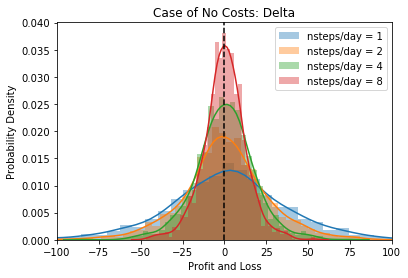

In [13]:
T = 30
NUM_STEPS = 30 * 1
MU = 0.05 / 365
IR = MU
VOL = 0.20 / np.sqrt(365)
S0 = 100
K = 100
NUM_SOLD_OPT = 100
KAPPA = 0.1
ALPHA = 0
GAMMA = 0.99

np.random.seed(999)
random.seed(999)

for NUM_STEPS in [T*1, T*2, T*4, T*8]:
    
    env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, ALPHA)
    num_states = env.num_states
    num_actions = env.num_actions
    
    brainDelta = BrainDelta(num_states, num_actions, is_rounded=True)
    agentDelta = AgentActionValueBase(brainDelta)
    
    trainer = TrainerBS(env, agentDelta)
    
    hists = trainer.run(2000, NUM_STEPS)
    pl = np.sum(hists[:, :, -1], axis=1)
    
    print('n_steps per day = {0:.0f}, AvePL = {1:.2f}, StdPL = {2:.2f}'.format(NUM_STEPS/T, pl.mean(), pl.std(ddof=1)))
    sns.distplot(pl, label="nsteps/day = {}".format(int(NUM_STEPS/T)))

plt.xlim(-100,100)
plt.axvline(0, color='k', ls='--')
plt.xlabel("Profit and Loss")
plt.ylabel("Probability Density")
plt.title("Case of No Costs: Delta")
plt.legend(frameon=True)
plt.show()

## Non-Zero Transaction Costs

n_steps per day = 1, AvePL = -26.40, StdPL = 38.94
n_steps per day = 2, AvePL = -34.19, StdPL = 28.46
n_steps per day = 4, AvePL = -44.89, StdPL = 23.31
n_steps per day = 8, AvePL = -60.05, StdPL = 24.51


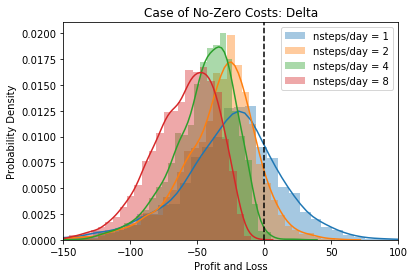

In [14]:
T = 30
NUM_STEPS = 30 * 1
MU = 0.05 / 365
IR = MU
VOL = 0.20 / np.sqrt(365)
S0 = 100
K = 100
NUM_SOLD_OPT = 100
KAPPA = 0.1
ALPHA = 0.001
GAMMA = 0.99

np.random.seed(999)
random.seed(999)

for NUM_STEPS in [T*1, T*2, T*4, T*8]:
    
    env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, ALPHA)
    num_states = env.num_states
    num_actions = env.num_actions
    
    brainDelta = BrainDelta(num_states, num_actions, is_rounded=True)
    agentDelta = AgentActionValueBase(brainDelta)
    
    trainer = TrainerBS(env, agentDelta)
    
    hists = trainer.run(2000, NUM_STEPS)
    pl = np.sum(hists[:, :, -1], axis=1)
    
    print('n_steps per day = {0:.0f}, AvePL = {1:.2f}, StdPL = {2:.2f}'.format(NUM_STEPS/T, pl.mean(), pl.std(ddof=1)))
    sns.distplot(pl, label="nsteps/day = {}".format(int(NUM_STEPS/T)))

plt.xlim(-150,100)
plt.axvline(0, color='k', ls='--')
plt.xlabel("Profit and Loss")
plt.ylabel("Probability Density")
plt.title("Case of No-Zero Costs: Delta")
plt.legend(frameon=True)
plt.show()

# Comparisons of Agents

## Zero Transaction Costs (DQN)

In [15]:
T = 30
NUM_STEPS = 30 * 1
MU = 0.05 / 365
IR = MU
VOL = 0.20 / np.sqrt(365)
S0 = 100
K = 100
NUM_SOLD_OPT = 100
KAPPA = 0.1
ALPHA = 0
GAMMA = 0.99
FREQ_UPDATE_TARGET = 5
CAPACITY = 10000
BATCH_SIZE = 32
file_name = './model_data/dqn_no_costs.h5'

np.random.seed(999)
random.seed(999)
os.environ['PYTHONHASHSEED'] = '0'
tf.set_random_seed(999)

env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, ALPHA)
num_states = env.num_states
num_actions = env.num_actions

brainDQN = BrainDQN(num_states, num_actions)
agentDQN = AgentActionValueBase(brainDQN)

trainer = TrainerBS(env, agentDQN)

NUM_EPISODES = 3000
if train_models:
    start = time.time()
    lst_std_pl, lst_r = trainer.train(NUM_EPISODES, NUM_STEPS)
    elapsed_time = time.time() - start
    print ("Elapsed Time = {0} [min]".format(np.round(elapsed_time/60.0,1)))
    brainDQN.save(file_name)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Episode 40:  P&L Std = 189.86
Episode 60:  P&L Std = 162.96
Episode 80:  P&L Std = 113.47
Episode 100:  P&L Std = 125.58
Episode 120:  P&L Std = 98.07
Episode 140:  P&L Std = 112.92
Episode 160:  P&L Std = 110.48
Episode 180:  P&L Std = 104.78
Episode 200:  P&L Std = 91.84
Episode 220:  P&L Std = 85.07
Episode 240:  P&L Std = 79.78
Episode 260:  P&L Std = 60.19
Episode 280:  P&L Std = 79.52
Episode 300:  P&L Std = 73.94
Episode 320:  P&L Std = 64.37
Episode 340:  P&L Std = 54.48
Episode 360:  P&L Std = 72.76
Episode 380:  P&L Std = 94.14
Episode 400:  P&L Std = 85.47
Episode 420:  P&L Std = 56.73
Episode 440:  P&L Std = 73.24
Episode 460:  P&L Std = 50.5
Episode 480:  P&L Std = 52.9
Episode 500:  P&L Std = 67.19
Episode 520:  P&L Std = 61.59
Episode 540:  P&L Std = 78.04
Episode 560:  P&L Std = 74.39
Episode 580:  P&L St

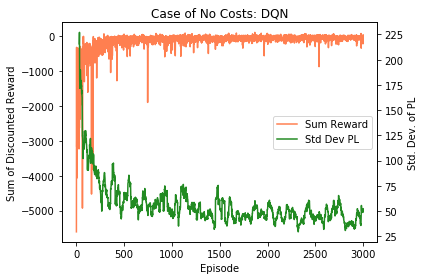

In [16]:
if train_models:
    xs = np.array(list(range(1,len(lst_std_pl)+1)))
    ys = np.array(lst_std_pl)
    zs = np.array(lst_r)
    
    fig = plt.figure(figsize=[6,4])
    
    ax = fig.add_subplot(111)
    ax.plot(xs, zs, color='coral', label='Sum Reward')
    ax.set_xlabel('Episode')
    ax.set_ylabel("Sum of Discounted Reward")
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(xs, ys, color='forestgreen', label='Std Dev PL')
    ax.set_ylabel("Std. Dev. of PL")
    h2, l2 = ax.get_legend_handles_labels()
    
    ax.legend(h1+h2, l1+l2, loc='center right')
    ax.set_title('Case of No Costs: DQN')
    plt.tight_layout()
    plt.show()

In [17]:
brainDQN = BrainDQN(num_states, num_actions)
brainDQN.load(file_name)
agentDQN = AgentActionValueBase(brainDQN)

trainer = TrainerBS(env, agentDQN)
q_hists = trainer.run(1000, NUM_STEPS)
q_pl = np.sum(q_hists[:, :, -1], axis=1)

brainDelta = BrainDelta(num_states, num_actions, is_rounded=True)
agentDelta = AgentActionValueBase(brainDelta)

trainer = TrainerBS(env, agentDelta)
d_hists = trainer.run(1000, NUM_STEPS)
d_pl = np.sum(d_hists[:, :, -1], axis=1)

### Histogram of PL

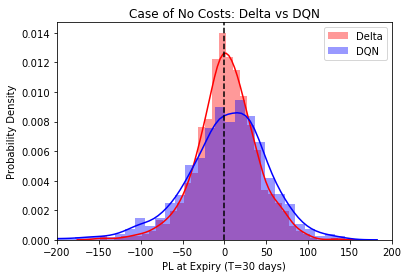

Delta: Ave = 2.24, Std = 35.99
DQN: Ave = 1.90, Std = 50.90


In [18]:
sns.distplot(d_pl, label="Delta", color='r',)
sns.distplot(q_pl, label="DQN", color='b',)
plt.axvline(0, color='k', ls='--')
plt.xlim(-200, 200)
plt.xlabel('PL at Expiry (T=30 days)')
plt.ylabel('Probability Density')
plt.title('Case of No Costs: Delta vs DQN')
plt.legend()
plt.show()

print("Delta: Ave = {0:.2f}, Std = {1:.2f}".format(d_pl.mean(), d_pl.std(ddof=1)))
print("DQN: Ave = {0:.2f}, Std = {1:.2f}".format(q_pl.mean(), q_pl.std(ddof=1)))

### Comparisons of Paths

In [19]:
def calc_t_S_nS(hists):
    t = hists[:, :, 0]
    W = hists[:, :, 1]
    S = S0 * np.exp(VOL*W + (MU - VOL**2 / 2) * t)
    nS = hists[:, :, 4]
    return t, S, nS

In [20]:
d_t, d_S, d_nS = calc_t_S_nS(d_hists)
q_t, q_S, q_nS = calc_t_S_nS(q_hists)

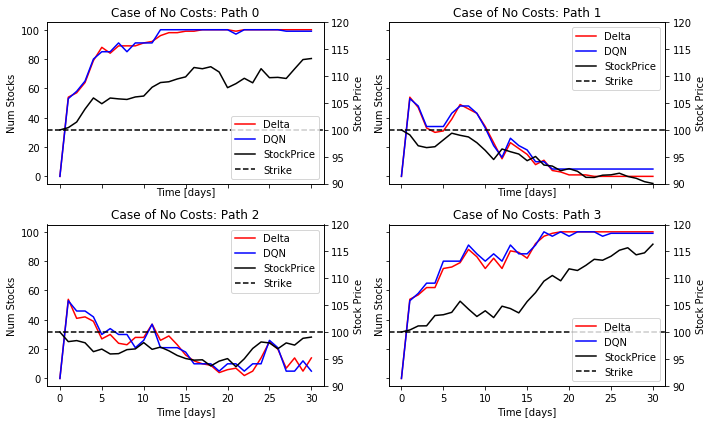

In [21]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=[10,6])
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(d_t[i,:], d_nS[i,:], label='Delta', color='r')
    ax.plot(q_t[i,:], q_nS[i,:], label='DQN', color='b')
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('Num Stocks')
    ax.set_ylim(-5,105)
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(d_t[i,:], d_S[i,:], label='StockPrice', color='k')
    ax.axhline(K, label='Strike', color='k', ls='--')
    ax.set_ylabel('Stock Price')
    ax.set_ylim(90,120)
    h2, l2 = ax.get_legend_handles_labels()
    loc = 'lower right' if i == 0 or i ==3 else 'upper right'
    ax.legend(h1+h2, l1+l2, frameon=True, loc=loc)
    ax.set_title('Case of No Costs: Path {}'.format(str(i)))

plt.tight_layout()
plt.show()

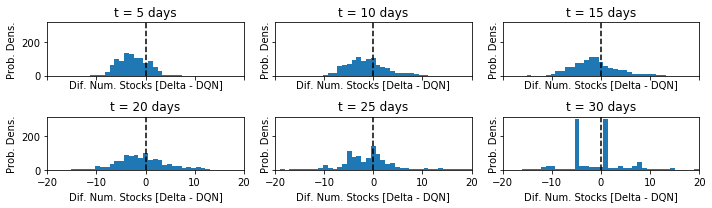

In [22]:
fig, axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=[10,3])
axes = axes.ravel()

diff_nS = d_nS - q_nS

for idx_time, ax in zip([5, 10, 15, 20, 25, 30], axes):
    xs = diff_nS[:, idx_time]
    ax.hist(xs, bins=41, range=(-20,20))
    ax.set_title("t = {} days".format(idx_time))
    ax.set_xlim(-20, 20)
    ax.set_xlabel('Dif. Num. Stocks [Delta - DQN]')
    ax.set_ylabel('Prob. Dens.')
    ax.axvline(0, color='k', ls='--')

plt.tight_layout()
plt.show()

## Zero Transaction Costs (DDPG)

In [24]:
T = 30
NUM_STEPS = 30 * 1
MU = 0.05 / 365
IR = MU
VOL = 0.20 / np.sqrt(365)
S0 = 100
K = 100
NUM_SOLD_OPT = 100
KAPPA = 0.1
ALPHA = 0
GAMMA = 0.99
CAPACITY = 10000
BATCH_SIZE = 32
file_name = './model_data/ddpg_no_costs'

np.random.seed(999)
random.seed(999)
os.environ['PYTHONHASHSEED'] = '0'
tf.set_random_seed(999)

env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, ALPHA)
num_states = env.num_states
num_actions = 1
act_rng = (0, NUM_SOLD_OPT)

rp = OrnsteinUhlenbeckProcess(theta=0.25, mu=0.0, sigma=NUM_SOLD_OPT/30, size=num_actions, dt=T/NUM_STEPS,)
agentDPG = AgentDDPG(num_states, num_actions, act_rng, random_process=rp, actor_lr=1e-5, critic_lr=1e-4, tau=1e-3)

trainer = TrainerBS(env, agentDPG)

NUM_EPISODES = 1000

if train_models:
    start = time.time()
    lst_std_pl, lst_r = trainer.train(NUM_EPISODES, NUM_STEPS)
    elapsed_time = time.time() - start
    print ("Elapsed Time = {0} [min]".format(np.round(elapsed_time/60.0,1)))
    agentDPG.save(file_name)

Episode 40:  P&L Std = 94.98
Episode 60:  P&L Std = 57.06
Episode 80:  P&L Std = 56.25
Episode 100:  P&L Std = 49.43
Episode 120:  P&L Std = 65.82
Episode 140:  P&L Std = 52.24
Episode 160:  P&L Std = 58.11
Episode 180:  P&L Std = 39.32
Episode 200:  P&L Std = 46.5
Episode 220:  P&L Std = 52.76
Episode 240:  P&L Std = 49.89
Episode 260:  P&L Std = 48.39
Episode 280:  P&L Std = 57.8
Episode 300:  P&L Std = 51.6
Episode 320:  P&L Std = 51.0
Episode 340:  P&L Std = 44.55
Episode 360:  P&L Std = 45.81
Episode 380:  P&L Std = 43.02
Episode 400:  P&L Std = 41.52
Episode 420:  P&L Std = 40.39
Episode 440:  P&L Std = 40.47
Episode 460:  P&L Std = 41.55
Episode 480:  P&L Std = 44.77
Episode 500:  P&L Std = 57.39
Episode 520:  P&L Std = 53.38
Episode 540:  P&L Std = 48.74
Episode 560:  P&L Std = 46.8
Episode 580:  P&L Std = 41.81
Episode 600:  P&L Std = 49.68
Episode 620:  P&L Std = 55.24
Episode 640:  P&L Std = 57.34
Episode 660:  P&L Std = 55.14
Episode 680:  P&L Std = 47.8
Episode 700:  P&L S

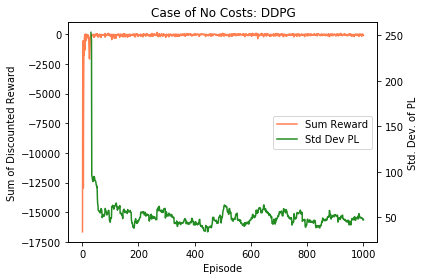

In [25]:
if train_models:
    xs = np.array(list(range(1,len(lst_std_pl)+1)))
    ys = np.array(lst_std_pl)
    zs = np.array(lst_r)
    
    fig = plt.figure(figsize=[6,4])
    
    ax = fig.add_subplot(111)
    ax.plot(xs, zs, color='coral', label='Sum Reward')
    ax.set_xlabel('Episode')
    ax.set_ylabel("Sum of Discounted Reward")
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(xs, ys, color='forestgreen', label='Std Dev PL')
    ax.set_ylabel("Std. Dev. of PL")
    h2, l2 = ax.get_legend_handles_labels()
    
    ax.legend(h1+h2, l1+l2, loc='center right')
    ax.set_title('Case of No Costs: DDPG')
    plt.tight_layout()
    plt.show()

In [26]:
agentDPG.load(file_name)
trainer = TrainerBS(env, agentDPG)
p_hists = trainer.run(1000, NUM_STEPS)
p_pl = np.sum(p_hists[:, :, -1], axis=1)

brainDelta = BrainDelta(num_states, num_actions, is_rounded=True)
agentDelta = AgentActionValueBase(brainDelta)

trainer = TrainerBS(env, agentDelta)
d_hists = trainer.run(1000, NUM_STEPS)
d_pl = np.sum(d_hists[:, :, -1], axis=1)

### Histogram of PL

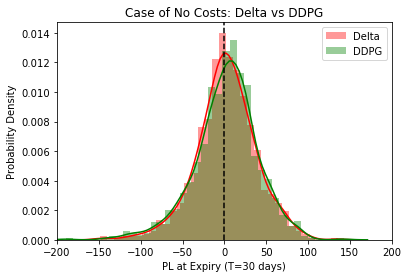

Delta: Ave = 2.24, Std = 35.99
DPG: Ave = 2.31, Std = 37.93


In [27]:
sns.distplot(d_pl, label="Delta", color='r',)
sns.distplot(p_pl, label="DDPG", color='g',)
plt.axvline(0, color='k', ls='--')
plt.xlim(-200, 200)
plt.xlabel('PL at Expiry (T=30 days)')
plt.ylabel('Probability Density')
plt.title('Case of No Costs: Delta vs DDPG')
plt.legend()
plt.show()

print("Delta: Ave = {0:.2f}, Std = {1:.2f}".format(d_pl.mean(), d_pl.std(ddof=1)))
print("DPG: Ave = {0:.2f}, Std = {1:.2f}".format(p_pl.mean(), p_pl.std(ddof=1)))

### Comparisons of Paths

In [28]:
d_t, d_S, d_nS = calc_t_S_nS(d_hists)
p_t, p_S, p_nS = calc_t_S_nS(p_hists)

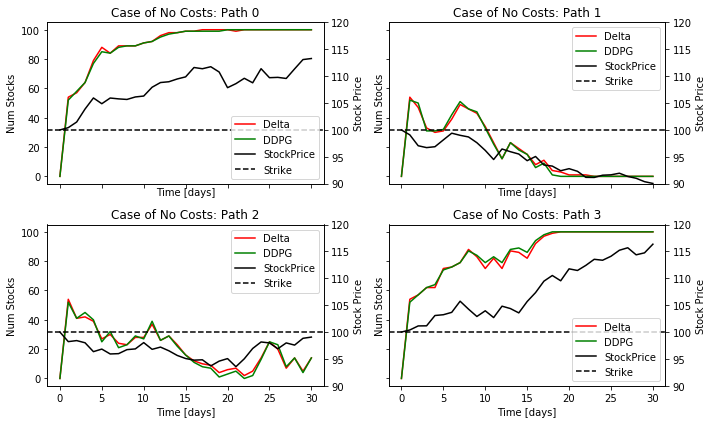

In [29]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=[10,6])
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(d_t[i,:], d_nS[i,:], label='Delta', color='r')
    ax.plot(p_t[i,:], p_nS[i,:], label='DDPG', color='g')
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('Num Stocks')
    ax.set_ylim(-5,105)
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(d_t[i,:], d_S[i,:], label='StockPrice', color='k')
    ax.axhline(K, label='Strike', color='k', ls='--')
    ax.set_ylabel('Stock Price')
    ax.set_ylim(90,120)
    h2, l2 = ax.get_legend_handles_labels()
    loc = 'lower right' if i == 0 or i ==3 else 'upper right'
    ax.legend(h1+h2, l1+l2, frameon=True, loc=loc)
    ax.set_title('Case of No Costs: Path {}'.format(str(i)))

plt.tight_layout()
plt.show()

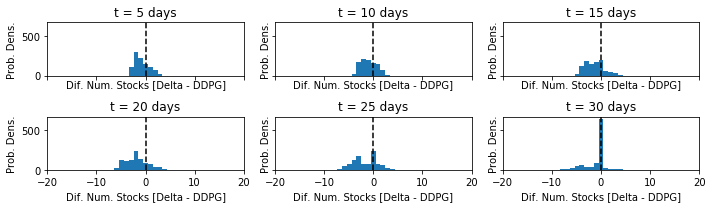

In [30]:
fig, axes = plt.subplots(2,3,sharex=True,sharey=True,figsize=[10,3])
axes = axes.ravel()

diff_nS = d_nS - p_nS

for idx_time, ax in zip([5, 10, 15, 20, 25, 30], axes):
    xs = diff_nS[:, idx_time]
    ax.hist(xs, bins=41, range=(-20,20))
    ax.set_title("t = {} days".format(idx_time))
    ax.set_xlim(-20, 20)
    ax.set_xlabel('Dif. Num. Stocks [Delta - DDPG]')
    ax.set_ylabel('Prob. Dens.')
    ax.axvline(0, color='k', ls='--')

plt.tight_layout()
plt.show()

## Zero Transaction Costs: DQN vs DDPG vs Delta

### Load Results

In [74]:
T = 30
NUM_STEPS = 30 * 1
MU = 0.05 / 365
IR = MU
VOL = 0.20 / np.sqrt(365)
S0 = 100
K = 100
NUM_SOLD_OPT = 100
KAPPA = 0.1
ALPHA = 0
GAMMA = 0.99
CAPACITY = 10000
BATCH_SIZE = 32
np.random.seed(999)
random.seed(999)
env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, ALPHA)

In [75]:
def load_and_run(num_paths=3000, file_ddpg='./model_data/ddpg_no_costs', file_dqn='./model_data/dqn_no_costs.h5'):
    
    # Results of DDPG agent
    num_states = env.num_states
    act_rng = (0, NUM_SOLD_OPT)
    rp = None
    agentDPG = AgentDDPG(num_states, 1, act_rng, random_process=rp, actor_lr=1e-5, critic_lr=1e-4, tau=1e-3)
    agentDPG.load(file_ddpg)
    
    trainer = TrainerBS(env, agentDPG)
    p_hists = trainer.run(num_paths, NUM_STEPS)
    p_pl = np.sum(p_hists[:, :, -1], axis=1)
    
    # Results of DQN agent
    brainDQN = BrainDQN(num_states, NUM_SOLD_OPT+1)
    brainDQN.load(file_dqn)
    agentDQN = AgentActionValueBase(brainDQN)
    
    trainer = TrainerBS(env, agentDQN)
    q_hists = trainer.run(num_paths, NUM_STEPS)
    q_pl = np.sum(q_hists[:, :, -1], axis=1)
    
    # Results of Delta agent
    brainDelta = BrainDelta(num_states, NUM_SOLD_OPT+1, is_rounded=True)
    agentDelta = AgentActionValueBase(brainDelta)
    
    trainer = TrainerBS(env, agentDelta)
    d_hists = trainer.run(num_paths, NUM_STEPS)
    d_pl = np.sum(d_hists[:, :, -1], axis=1)
    
    return d_hists, p_hists, q_hists, d_pl, p_pl, q_pl

In [76]:
d_hists, p_hists, q_hists, d_pl, p_pl, q_pl = load_and_run()

In [77]:
d_t, d_S, d_nS = calc_t_S_nS(d_hists)
p_t, p_S, p_nS = calc_t_S_nS(p_hists)
q_t, q_S, q_nS = calc_t_S_nS(q_hists)

### Histogram of PL

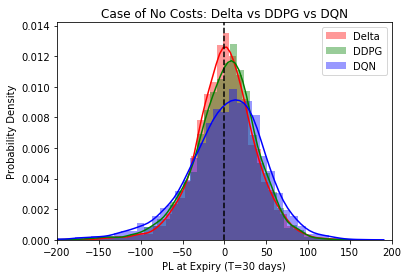

Delta: Ave = 0.60, Std = 36.30
DDPG: Ave = 0.72, Std = 38.88
DQN: Ave = 1.13, Std = 48.22


In [78]:
sns.distplot(d_pl, label="Delta", color='r', hist_kws={"alpha":0.4})
sns.distplot(p_pl, label="DDPG", color='g', hist_kws={"alpha":0.4})
sns.distplot(q_pl, label="DQN", color='b', hist_kws={"alpha":0.4})

plt.axvline(0, color='k', ls='--')
plt.xlim(-200, 200)
plt.xlabel('PL at Expiry (T=30 days)')
plt.ylabel('Probability Density')
plt.title('Case of No Costs: Delta vs DDPG vs DQN')
plt.legend()
plt.show()

print("Delta: Ave = {0:.2f}, Std = {1:.2f}".format(d_pl.mean(), d_pl.std(ddof=1)))
print("DDPG: Ave = {0:.2f}, Std = {1:.2f}".format(p_pl.mean(), p_pl.std(ddof=1)))
print("DQN: Ave = {0:.2f}, Std = {1:.2f}".format(q_pl.mean(), q_pl.std(ddof=1)))

### Comparisons of Paths

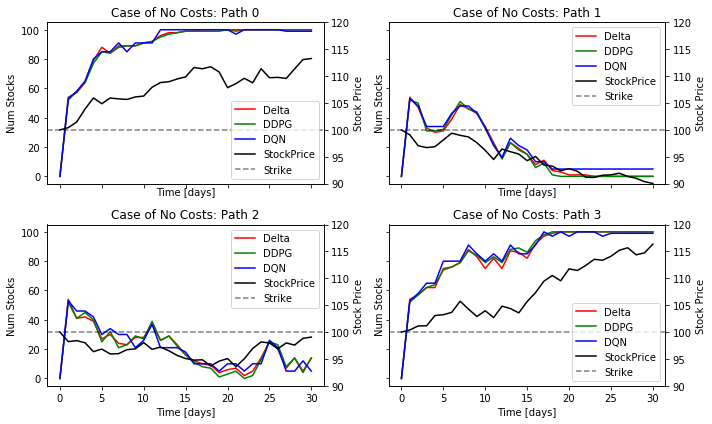

In [79]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=[10,6])
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(d_t[i,:], d_nS[i,:], label='Delta', color='r')
    ax.plot(p_t[i,:], p_nS[i,:], label='DDPG', color='g')
    ax.plot(q_t[i,:], q_nS[i,:], label='DQN', color='b')
    
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('Num Stocks')
    ax.set_ylim(-5,105)
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(d_t[i,:], d_S[i,:], label='StockPrice', color='k')
    ax.axhline(K, label='Strike', color='k', ls='--', alpha=0.5)
    
    ax.set_ylabel('Stock Price')
    ax.set_ylim(90,120)
    h2, l2 = ax.get_legend_handles_labels()
    
    loc = 'lower right' if i == 0 or i ==3 else 'upper right'
    ax.legend(h1+h2, l1+l2, frameon=True, loc=loc)
    ax.set_title('Case of No Costs: Path {}'.format(str(i)))

plt.tight_layout()
plt.show()

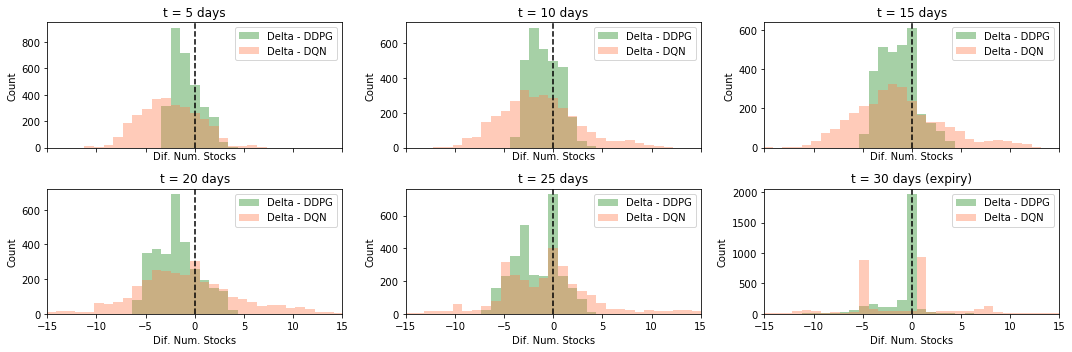

In [80]:
fig, axes = plt.subplots(2,3,sharex=True,sharey=False,figsize=[15,5])
axes = axes.ravel()

diff1_nS = d_nS - p_nS
diff2_nS = d_nS - q_nS

for idx_time, ax in zip([5, 10, 15, 20, 25, 30], axes):
    
    xs = diff1_nS[:, idx_time]
    ax.hist(xs, bins=41, range=(-20,20), alpha=0.4, label='Delta - DDPG', color='forestgreen')
    
    xs = diff2_nS[:, idx_time]
    ax.hist(xs, bins=41, range=(-20,20), alpha=0.4, label='Delta - DQN', color='coral')
    
    if idx_time < T:
        ax.set_title("t = {} days".format(idx_time))
    else:
        ax.set_title("t = {} days (expiry)".format(idx_time))
    ax.set_xlim(-15, 15)
    ax.set_xlabel('Dif. Num. Stocks')
    ax.set_ylabel('Count')
    ax.legend(frameon=True)
    ax.axvline(0, color='k', ls='--')

plt.tight_layout()
plt.show()

## Non-Zero Transaction Costs

### DQN: Various multipliers of the cost

In [31]:
T = 30
NUM_STEPS = 30 * 1
MU = 0.05 / 365
IR = MU
VOL = 0.20 / np.sqrt(365)
S0 = 100
K = 100
NUM_SOLD_OPT = 100
KAPPA = 0.1
# ALPHA = 0
GAMMA = 0.99
CAPACITY = 10000
BATCH_SIZE = 32
NUM_EPISODES = 3000

In [32]:
def train_dqn_model():
    
    # Initialize
    np.random.seed(999)
    random.seed(999)
    os.environ['PYTHONHASHSEED'] = '0'
    tf.set_random_seed(999)
    
    # Make model
    env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, ALPHA)
    num_states = env.num_states
    num_actions = env.num_actions
    
    brainDQN = BrainDQN(num_states, num_actions)
    agentDQN = AgentActionValueBase(brainDQN)
    
    trainer = TrainerBS(env, agentDQN)
    
    # Train model
    start = time.time()
    lst_std_pl, lst_r= trainer.train(NUM_EPISODES, NUM_STEPS)
    elapsed_time = time.time() - start
    print ("Elapsed Time = {0} [min]".format(np.round(elapsed_time/60.0,1)))
    brainDQN.save(file_name)
    
    # Show history of sum reward
    xs = np.array(list(range(1,len(lst_std_pl)+1)))
    ys = np.array(lst_std_pl)
    zs = np.array(lst_r)
    
    fig = plt.figure(figsize=[6,4])
    
    ax = fig.add_subplot(111)
    ax.plot(xs, zs, color='coral', label='Sum Reward')
    ax.set_xlabel('Episode')
    ax.set_ylabel("Sum of Discounted Reward")
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(xs, ys, color='forestgreen', label='Std Dev PL')
    ax.set_ylabel("Std. Dev. of PL")
    h2, l2 = ax.get_legend_handles_labels()
    
    ax.legend(h1+h2, l1+l2, loc='center right')
    ax.set_title('Case of Non-Zero Costs: DQN')
    plt.tight_layout()
    plt.show()
    
    # Show histogram of PL
    q_hists = trainer.run(1000, NUM_STEPS)
    q_pl = np.sum(q_hists[:, :, -1], axis=1)
    
    brainDelta = BrainDelta(num_states, num_actions, is_rounded=True)
    agentDelta = AgentActionValueBase(brainDelta)
    trainer = TrainerBS(env, agentDelta)
    d_hists = trainer.run(1000, NUM_STEPS)
    d_pl = np.sum(d_hists[:, :, -1], axis=1)
    
    sns.distplot(d_pl, label="Delta", color='r',)
    sns.distplot(q_pl, label="DQN", color='b',)
    
    plt.axvline(0, color='k', ls='--')
    plt.xlim(-500, 200)
    plt.xlabel('PL at Expiry (T=30 days)')
    plt.ylabel('Probability Density')
    plt.title('Case of Non-Zero Costs: Delta vs DQN')
    plt.legend()
    plt.show()
    
    print("Delta: Ave = {0:.2f}, Std = {1:.2f}".format(d_pl.mean(), d_pl.std(ddof=1)))
    print("DQN: Ave = {0:.2f}, Std = {1:.2f}".format(q_pl.mean(), q_pl.std(ddof=1)))

Episode 40:  P&L Std = 173.66
Episode 60:  P&L Std = 199.18
Episode 80:  P&L Std = 169.03
Episode 100:  P&L Std = 143.17
Episode 120:  P&L Std = 110.64
Episode 140:  P&L Std = 111.01
Episode 160:  P&L Std = 129.11
Episode 180:  P&L Std = 91.53
Episode 200:  P&L Std = 91.5
Episode 220:  P&L Std = 104.06
Episode 240:  P&L Std = 85.4
Episode 260:  P&L Std = 80.62
Episode 280:  P&L Std = 75.26
Episode 300:  P&L Std = 75.5
Episode 320:  P&L Std = 83.02
Episode 340:  P&L Std = 67.64
Episode 360:  P&L Std = 64.71
Episode 380:  P&L Std = 63.2
Episode 400:  P&L Std = 81.11
Episode 420:  P&L Std = 63.8
Episode 440:  P&L Std = 49.58
Episode 460:  P&L Std = 44.65
Episode 480:  P&L Std = 60.42
Episode 500:  P&L Std = 56.37
Episode 520:  P&L Std = 59.18
Episode 540:  P&L Std = 68.87
Episode 560:  P&L Std = 53.86
Episode 580:  P&L Std = 52.39
Episode 600:  P&L Std = 45.51
Episode 620:  P&L Std = 47.08
Episode 640:  P&L Std = 45.99
Episode 660:  P&L Std = 61.92
Episode 680:  P&L Std = 54.44
Episode 70

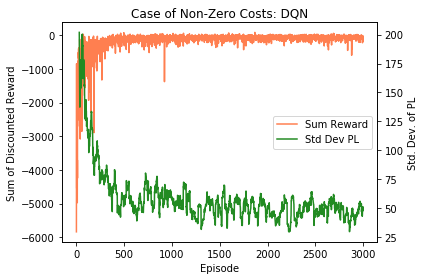

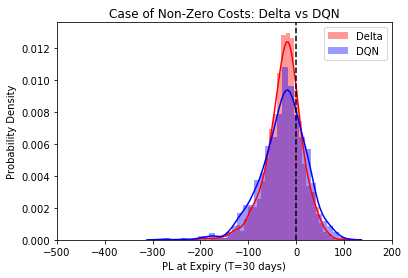

Delta: Ave = -25.17, Std = 37.96
DQN: Ave = -26.56, Std = 47.50


In [33]:
ALPHA = 0.001
file_name = './model_data/dqn_alpha1e-3.h5'
if train_models: train_dqn_model()

Episode 40:  P&L Std = 323.6
Episode 60:  P&L Std = 318.13
Episode 80:  P&L Std = 288.56
Episode 100:  P&L Std = 231.57
Episode 120:  P&L Std = 227.63
Episode 140:  P&L Std = 162.94
Episode 160:  P&L Std = 153.81
Episode 180:  P&L Std = 129.14
Episode 200:  P&L Std = 130.41
Episode 220:  P&L Std = 102.33
Episode 240:  P&L Std = 81.51
Episode 260:  P&L Std = 75.44
Episode 280:  P&L Std = 73.94
Episode 300:  P&L Std = 61.65
Episode 320:  P&L Std = 66.73
Episode 340:  P&L Std = 68.59
Episode 360:  P&L Std = 62.5
Episode 380:  P&L Std = 77.81
Episode 400:  P&L Std = 84.02
Episode 420:  P&L Std = 62.32
Episode 440:  P&L Std = 52.2
Episode 460:  P&L Std = 47.51
Episode 480:  P&L Std = 63.62
Episode 500:  P&L Std = 83.28
Episode 520:  P&L Std = 71.43
Episode 540:  P&L Std = 92.88
Episode 560:  P&L Std = 86.24
Episode 580:  P&L Std = 67.97
Episode 600:  P&L Std = 65.67
Episode 620:  P&L Std = 50.93
Episode 640:  P&L Std = 61.35
Episode 660:  P&L Std = 78.96
Episode 680:  P&L Std = 61.33
Episod

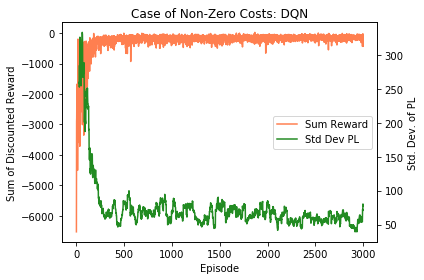

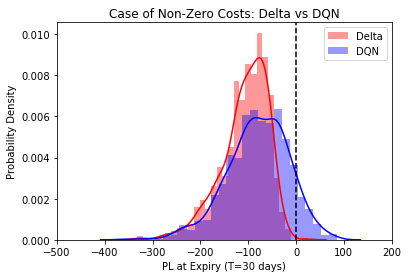

Delta: Ave = -107.39, Std = 50.17
DQN: Ave = -79.94, Std = 64.75


In [34]:
ALPHA = 0.004
file_name = './model_data/dqn_alpha4e-3.h5'
if train_models: train_dqn_model()

Episode 40:  P&L Std = 379.98
Episode 60:  P&L Std = 273.42
Episode 80:  P&L Std = 201.6
Episode 100:  P&L Std = 253.24
Episode 120:  P&L Std = 231.87
Episode 140:  P&L Std = 197.75
Episode 160:  P&L Std = 137.49
Episode 180:  P&L Std = 157.63
Episode 200:  P&L Std = 218.05
Episode 220:  P&L Std = 173.07
Episode 240:  P&L Std = 195.47
Episode 260:  P&L Std = 196.09
Episode 280:  P&L Std = 147.33
Episode 300:  P&L Std = 153.64
Episode 320:  P&L Std = 146.92
Episode 340:  P&L Std = 122.62
Episode 360:  P&L Std = 141.35
Episode 380:  P&L Std = 113.69
Episode 400:  P&L Std = 76.73
Episode 420:  P&L Std = 96.0
Episode 440:  P&L Std = 96.07
Episode 460:  P&L Std = 87.1
Episode 480:  P&L Std = 69.94
Episode 500:  P&L Std = 95.31
Episode 520:  P&L Std = 120.14
Episode 540:  P&L Std = 137.41
Episode 560:  P&L Std = 105.65
Episode 580:  P&L Std = 84.87
Episode 600:  P&L Std = 109.29
Episode 620:  P&L Std = 94.63
Episode 640:  P&L Std = 85.22
Episode 660:  P&L Std = 84.78
Episode 680:  P&L Std = 

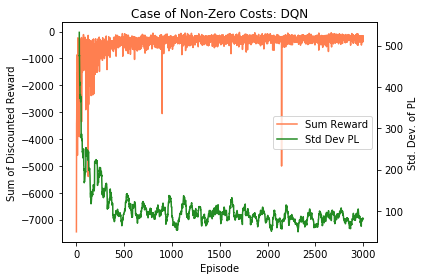

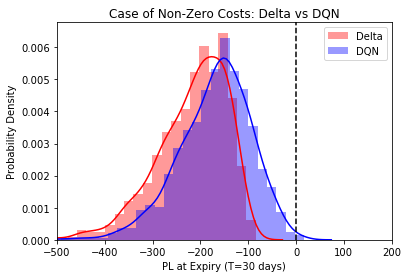

Delta: Ave = -217.01, Std = 73.74
DQN: Ave = -169.38, Std = 74.89


In [35]:
ALPHA = 0.008
file_name = './model_data/dqn_alpha8e-3.h5'
if train_models: train_dqn_model()

### DDPG: Various multipliers of the cost

In [36]:
T = 30
NUM_STEPS = 30 * 1
MU = 0.05 / 365
IR = MU
VOL = 0.20 / np.sqrt(365)
S0 = 100
K = 100
NUM_SOLD_OPT = 100
KAPPA = 0.1
# ALPHA = 0
GAMMA = 0.99
CAPACITY = 10000
BATCH_SIZE = 32
NUM_EPISODES = 1000

In [37]:
def train_ddpg_model():
    
    # Initialize
    np.random.seed(999)
    random.seed(999)
    os.environ['PYTHONHASHSEED'] = '0'
    tf.set_random_seed(999)
    
    # Make model
    env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, ALPHA)
    num_states = env.num_states
    num_actions = 1
    act_rng = (0, NUM_SOLD_OPT)
    
    rp = OrnsteinUhlenbeckProcess(theta=0.25, mu=0.0, sigma=NUM_SOLD_OPT/30, size=num_actions, dt=T/NUM_STEPS,)
    agentDPG = AgentDDPG(num_states, num_actions, act_rng, random_process=rp, actor_lr=1e-5, critic_lr=1e-4, tau=1e-3)
    
    trainer = TrainerBS(env, agentDPG)
    
    # Train model
    start = time.time()
    lst_std_pl, lst_r = trainer.train(NUM_EPISODES, NUM_STEPS)
    elapsed_time = time.time() - start
    print ("Elapsed Time = {0} [min]".format(np.round(elapsed_time/60.0,1)))
    agentDPG.save(file_name)
    
    # Show hisotry of sum reward
    xs = np.array(list(range(1,len(lst_std_pl)+1)))
    ys = np.array(lst_std_pl)
    zs = np.array(lst_r)
    
    fig = plt.figure(figsize=[6,4])
    
    ax = fig.add_subplot(111)
    ax.plot(xs, zs, color='coral', label='Sum Reward')
    ax.set_xlabel('Episode')
    ax.set_ylabel("Sum of Discounted Reward")
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(xs, ys, color='forestgreen', label='Std Dev PL')
    ax.set_ylabel("Std. Dev. of PL")
    h2, l2 = ax.get_legend_handles_labels()
    
    ax.legend(h1+h2, l1+l2, loc='center right')
    ax.set_title('Case of Non-Zero Costs: DDPG')
    plt.tight_layout()
    plt.show()
    
    # Show histogram of PL
    p_hists = trainer.run(1000, NUM_STEPS)
    p_pl = np.sum(p_hists[:, :, -1], axis=1)
    
    brainDelta = BrainDelta(num_states, num_actions, is_rounded=True)
    agentDelta = AgentActionValueBase(brainDelta)
    
    trainer = TrainerBS(env, agentDelta)
    d_hists = trainer.run(1000, NUM_STEPS)
    d_pl = np.sum(d_hists[:, :, -1], axis=1)
    
    sns.distplot(d_pl, label="Delta", color='r',)
    sns.distplot(p_pl, label="DDPG", color='g',)
    plt.axvline(0, color='k', ls='--')
    plt.xlim(-500, 200)
    plt.xlabel('PL at Expiry (T=30 days)')
    plt.ylabel('Probability Density')
    plt.title('Case of Non-Zero Costs: Delta vs DDPG')
    plt.legend()
    plt.show()
    
    print("Delta: Ave = {0:.2f}, Std = {1:.2f}".format(d_pl.mean(), d_pl.std(ddof=1)))
    print("DPG: Ave = {0:.2f}, Std = {1:.2f}".format(p_pl.mean(), p_pl.std(ddof=1)))

Episode 40:  P&L Std = 103.48
Episode 60:  P&L Std = 77.3
Episode 80:  P&L Std = 49.47
Episode 100:  P&L Std = 44.01
Episode 120:  P&L Std = 56.25
Episode 140:  P&L Std = 51.11
Episode 160:  P&L Std = 67.48
Episode 180:  P&L Std = 52.6
Episode 200:  P&L Std = 54.72
Episode 220:  P&L Std = 57.05
Episode 240:  P&L Std = 42.62
Episode 260:  P&L Std = 47.35
Episode 280:  P&L Std = 59.2
Episode 300:  P&L Std = 61.71
Episode 320:  P&L Std = 61.62
Episode 340:  P&L Std = 50.82
Episode 360:  P&L Std = 49.58
Episode 380:  P&L Std = 48.86
Episode 400:  P&L Std = 49.17
Episode 420:  P&L Std = 36.54
Episode 440:  P&L Std = 37.57
Episode 460:  P&L Std = 40.32
Episode 480:  P&L Std = 44.82
Episode 500:  P&L Std = 56.97
Episode 520:  P&L Std = 55.2
Episode 540:  P&L Std = 58.62
Episode 560:  P&L Std = 56.35
Episode 580:  P&L Std = 43.49
Episode 600:  P&L Std = 47.67
Episode 620:  P&L Std = 55.66
Episode 640:  P&L Std = 59.23
Episode 660:  P&L Std = 60.12
Episode 680:  P&L Std = 47.04
Episode 700:  P&

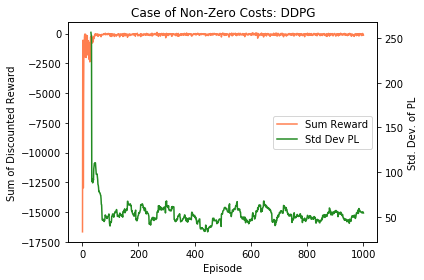

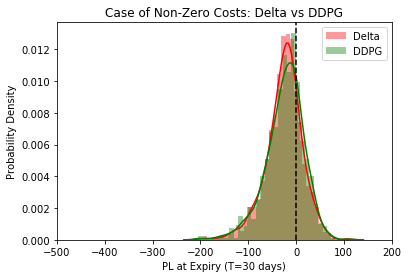

Delta: Ave = -25.17, Std = 37.96
DPG: Ave = -23.45, Std = 40.05


In [38]:
ALPHA = 0.001
file_name = './model_data/ddpg_alpha1e-3'
if train_models: train_ddpg_model()

Episode 40:  P&L Std = 128.18
Episode 60:  P&L Std = 104.13
Episode 80:  P&L Std = 58.97
Episode 100:  P&L Std = 51.73
Episode 120:  P&L Std = 62.28
Episode 140:  P&L Std = 59.17
Episode 160:  P&L Std = 72.05
Episode 180:  P&L Std = 62.18
Episode 200:  P&L Std = 61.08
Episode 220:  P&L Std = 67.52
Episode 240:  P&L Std = 54.42
Episode 260:  P&L Std = 57.09
Episode 280:  P&L Std = 70.36
Episode 300:  P&L Std = 69.44
Episode 320:  P&L Std = 75.9
Episode 340:  P&L Std = 59.29
Episode 360:  P&L Std = 62.52
Episode 380:  P&L Std = 63.7
Episode 400:  P&L Std = 63.82
Episode 420:  P&L Std = 39.47
Episode 440:  P&L Std = 46.11
Episode 460:  P&L Std = 52.97
Episode 480:  P&L Std = 63.33
Episode 500:  P&L Std = 69.78
Episode 520:  P&L Std = 68.47
Episode 540:  P&L Std = 65.4
Episode 560:  P&L Std = 63.45
Episode 580:  P&L Std = 47.33
Episode 600:  P&L Std = 59.46
Episode 620:  P&L Std = 62.51
Episode 640:  P&L Std = 72.71
Episode 660:  P&L Std = 71.07
Episode 680:  P&L Std = 53.26
Episode 700:  

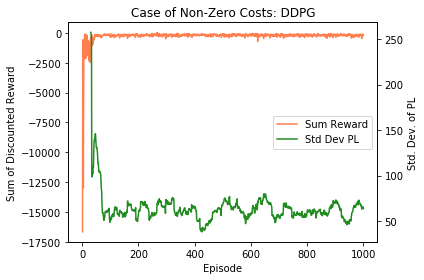

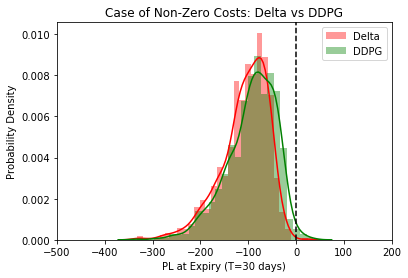

Delta: Ave = -107.39, Std = 50.17
DPG: Ave = -92.83, Std = 51.47


In [39]:
ALPHA = 0.004
file_name = './model_data/ddpg_alpha4e-3'
if train_models: train_ddpg_model()

Episode 40:  P&L Std = 150.12
Episode 60:  P&L Std = 141.56
Episode 80:  P&L Std = 80.77
Episode 100:  P&L Std = 65.39
Episode 120:  P&L Std = 71.69
Episode 140:  P&L Std = 69.59
Episode 160:  P&L Std = 74.45
Episode 180:  P&L Std = 62.58
Episode 200:  P&L Std = 81.42
Episode 220:  P&L Std = 80.65
Episode 240:  P&L Std = 74.75
Episode 260:  P&L Std = 81.45
Episode 280:  P&L Std = 92.0
Episode 300:  P&L Std = 80.55
Episode 320:  P&L Std = 104.75
Episode 340:  P&L Std = 72.59
Episode 360:  P&L Std = 76.55
Episode 380:  P&L Std = 86.8
Episode 400:  P&L Std = 90.61
Episode 420:  P&L Std = 60.15
Episode 440:  P&L Std = 65.66
Episode 460:  P&L Std = 82.43
Episode 480:  P&L Std = 91.2
Episode 500:  P&L Std = 87.94
Episode 520:  P&L Std = 99.44
Episode 540:  P&L Std = 98.33
Episode 560:  P&L Std = 121.56
Episode 580:  P&L Std = 87.52
Episode 600:  P&L Std = 93.35
Episode 620:  P&L Std = 107.57
Episode 640:  P&L Std = 119.7
Episode 660:  P&L Std = 114.28
Episode 680:  P&L Std = 88.04
Episode 70

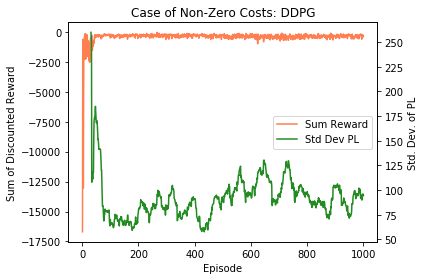

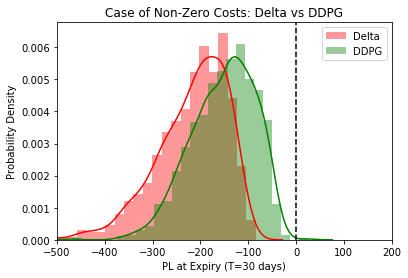

Delta: Ave = -217.01, Std = 73.74
DPG: Ave = -152.19, Std = 66.51


In [40]:
ALPHA = 0.008
file_name = './model_data/ddpg_alpha8e-3'
if train_models: train_ddpg_model()

## Non-Zero Transaction Costs: DQN vs DDPG vs Delta

### Load Results

In [83]:
T = 30
NUM_STEPS = 30 * 1
MU = 0.05 / 365
IR = MU
VOL = 0.20 / np.sqrt(365)
S0 = 100
K = 100
NUM_SOLD_OPT = 100
KAPPA = 0.1
GAMMA = 0.99
CAPACITY = 10000
BATCH_SIZE = 32

In [84]:
env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, alpha=1e-3)
d_hists1, p_hists1, q_hists1, d_pl1, p_pl1, q_pl1 = load_and_run(3000, './model_data/ddpg_alpha1e-3', './model_data/dqn_alpha1e-3.h5')

env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, alpha=4e-3)
d_hists2, p_hists2, q_hists2, d_pl2, p_pl2, q_pl2 = load_and_run(3000, './model_data/ddpg_alpha4e-3', './model_data/dqn_alpha4e-3.h5')

env = EnvironmentBS(T, NUM_STEPS, MU, IR, VOL, S0, K, NUM_SOLD_OPT, KAPPA, alpha=8e-3)
d_hists3, p_hists3, q_hists3, d_pl3, p_pl3, q_pl3 = load_and_run(3000, './model_data/ddpg_alpha8e-3', './model_data/dqn_alpha8e-3.h5')

### Histogram of PL

In [139]:
def plot_three_pl_hists(d_pl, p_pl, q_pl, alpha, ax, hist=True):
    
    sns.distplot(d_pl, label="Delta", color='r', hist_kws={"alpha":0.3}, ax=ax, hist=hist)
    sns.distplot(p_pl, label="DDPG", color='g', hist_kws={"alpha":0.3}, ax=ax, hist=hist)
    sns.distplot(q_pl, label="DQN", color='b', hist_kws={"alpha":0.3}, ax=ax, hist=hist)
    
    ax.axvline(0, color='k', ls='--')
    ax.set_xlim(-400, 150)
    ax.set_xlabel('PL at Expiry (T=30 days)')
    ax.set_ylabel('Probability Density')
    ax.set_title('Case of Non-Zero Costs: Alpha = {0:.1e}'.format(alpha))
    ax.legend(frameon=True)
    
    print("Case of Alpha = {0:.1e}".format(alpha))
    print("Delta: Ave = {0:.2f}, Std = {1:.2f}, 1%Tile = {2:.2f}".format(d_pl.mean(), d_pl.std(ddof=1), stats.scoreatpercentile(d_pl, 1)))
    print("DDPG: Ave = {0:.2f}, Std = {1:.2f}, 1%Tile = {2:.2f}".format(p_pl.mean(), p_pl.std(ddof=1), stats.scoreatpercentile(p_pl, 1)))
    print("DQN: Ave = {0:.2f}, Std = {1:.2f}, 1%Tile = {2:.2f}".format(q_pl.mean(), q_pl.std(ddof=1), stats.scoreatpercentile(q_pl, 1)))
    print("")

Case of Alpha = 1.0e-03
Delta: Ave = -26.72, Std = 38.30, 1%Tile = -137.83
DDPG: Ave = -24.80, Std = 40.76, 1%Tile = -144.94
DQN: Ave = -27.18, Std = 46.44, 1%Tile = -159.23

Case of Alpha = 4.0e-03
Delta: Ave = -108.67, Std = 50.60, 1%Tile = -262.38
DDPG: Ave = -94.00, Std = 52.49, 1%Tile = -254.46
DQN: Ave = -83.44, Std = 64.35, 1%Tile = -254.72

Case of Alpha = 8.0e-03
Delta: Ave = -217.94, Std = 74.32, 1%Tile = -437.02
DDPG: Ave = -154.43, Std = 64.98, 1%Tile = -326.55
DQN: Ave = -167.59, Std = 75.63, 1%Tile = -389.44



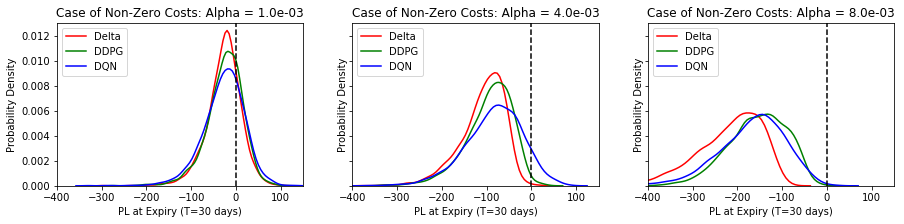

In [140]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=[15,3])

plot_three_pl_hists(d_pl1, p_pl1, q_pl1, 1e-3, axes[0], False)
plot_three_pl_hists(d_pl2, p_pl2, q_pl2, 4e-3, axes[1], False)
plot_three_pl_hists(d_pl3, p_pl3, q_pl3, 8e-3, axes[2], False)

### Comparisons of Paths

In [261]:
d_t, d_S, d_nS = calc_t_S_nS(d_hists3)
p_t, p_S, p_nS = calc_t_S_nS(p_hists3)
q_t, q_S, q_nS = calc_t_S_nS(q_hists3)

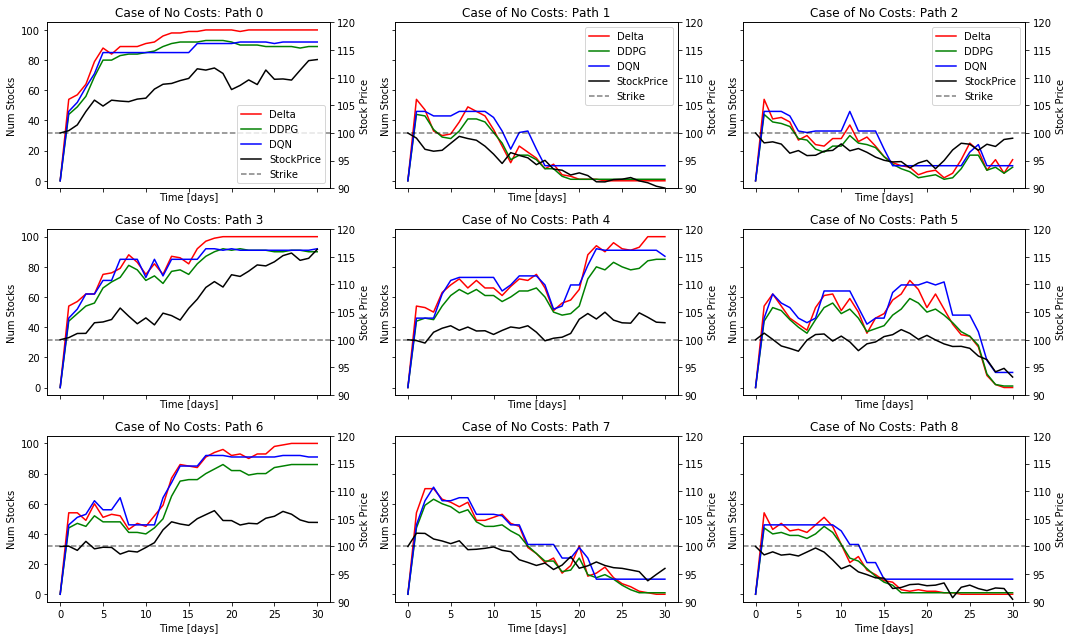

In [262]:
fig, axes = plt.subplots(3,3,sharex=True,sharey=True,figsize=[15,9])
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(d_t[i,:], d_nS[i,:], label='Delta', color='r')
    ax.plot(p_t[i,:], p_nS[i,:], label='DDPG', color='g')
    ax.plot(q_t[i,:], q_nS[i,:], label='DQN', color='b')
    
    ax.set_xlabel('Time [days]')
    ax.set_ylabel('Num Stocks')
    ax.set_ylim(-5,105)
    h1, l1 = ax.get_legend_handles_labels()
    
    ax = ax.twinx()
    ax.plot(d_t[i,:], d_S[i,:], label='StockPrice', color='k')
    ax.axhline(K, label='Strike', color='k', ls='--', alpha=0.5)
    
    ax.set_ylabel('Stock Price')
    ax.set_ylim(90,120)
    h2, l2 = ax.get_legend_handles_labels()
    
    if i <= 2:
        loc = 'lower right' if i == 0 else 'upper right'
        ax.legend(h1+h2, l1+l2, frameon=True, loc=loc)
    ax.set_title('Case of No Costs: Path {}'.format(str(i)))

plt.tight_layout()
plt.show()

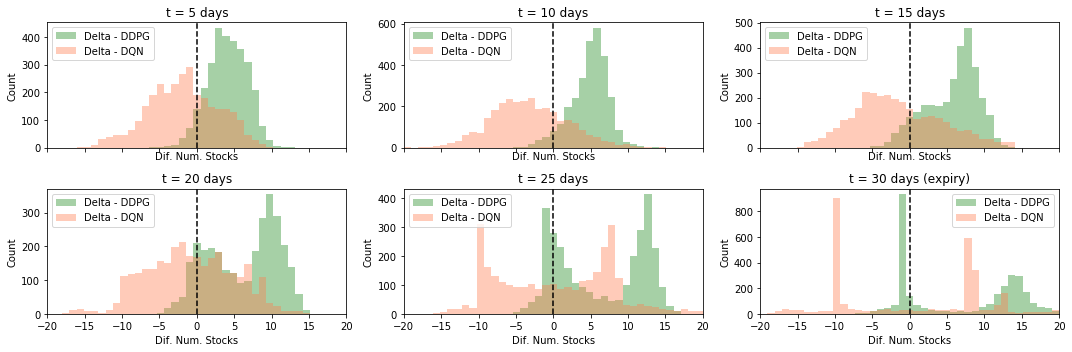

In [263]:
fig, axes = plt.subplots(2,3,sharex=True,sharey=False,figsize=[15,5])
axes = axes.ravel()

diff1_nS = d_nS - p_nS
diff2_nS = d_nS - q_nS

for idx_time, ax in zip([5, 10, 15, 20, 25, 30], axes):
    
    xs = diff1_nS[:, idx_time]
    ax.hist(xs, bins=41, range=(-20,20), alpha=0.4, label='Delta - DDPG', color='forestgreen')
    
    xs = diff2_nS[:, idx_time]
    ax.hist(xs, bins=41, range=(-20,20), alpha=0.4, label='Delta - DQN', color='coral')
    
    if idx_time < T:
        ax.set_title("t = {} days".format(idx_time))
    else:
        ax.set_title("t = {} days (expiry)".format(idx_time))
    ax.set_xlim(-20, 20)
    ax.set_xlabel('Dif. Num. Stocks')
    ax.set_ylabel('Count')
    ax.legend(frameon=True)
    ax.axvline(0, color='k', ls='--')

plt.tight_layout()
plt.show()

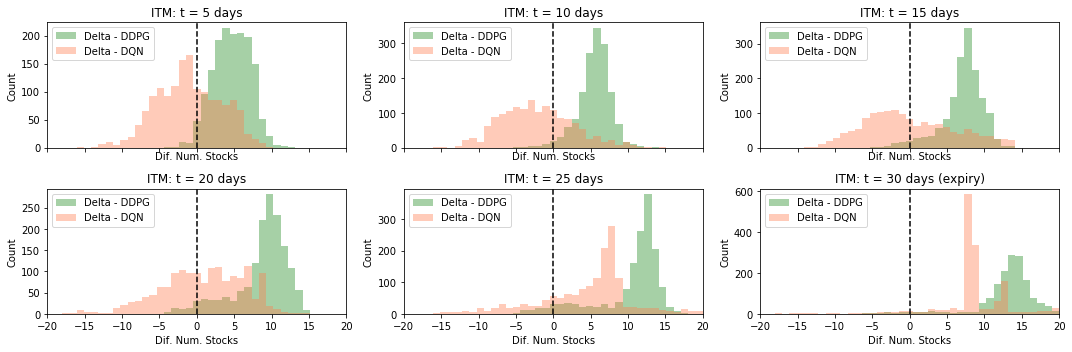

In [264]:
fig, axes = plt.subplots(2,3,sharex=True,sharey=False,figsize=[15,5])
axes = axes.ravel()

diff1_nS = d_nS - p_nS
diff2_nS = d_nS - q_nS

for idx_time, ax in zip([5, 10, 15, 20, 25, 30], axes):
    
    xs = diff1_nS[:, idx_time]
    df = pd.DataFrame()
    df['diffS'] = xs
    df['S'] = d_S[:, -1]
    xs = df[df['S'] > K]['diffS'].values
    ax.hist(xs, bins=41, range=(-20,20), alpha=0.4, label='Delta - DDPG', color='forestgreen')
    
    xs = diff2_nS[:, idx_time]
    df = pd.DataFrame()
    df['diffS'] = xs
    df['S'] = d_S[:, -1]
    xs = df[df['S'] > K]['diffS'].values
    ax.hist(xs, bins=41, range=(-20,20), alpha=0.4, label='Delta - DQN', color='coral')
    
    if idx_time < T:
        ax.set_title("ITM: t = {} days".format(idx_time))
    else:
        ax.set_title("ITM: t = {} days (expiry)".format(idx_time))
    ax.set_xlim(-20, 20)
    ax.set_xlabel('Dif. Num. Stocks')
    ax.set_ylabel('Count')
    ax.legend(frameon=True)
    ax.axvline(0, color='k', ls='--')

plt.tight_layout()
plt.show()

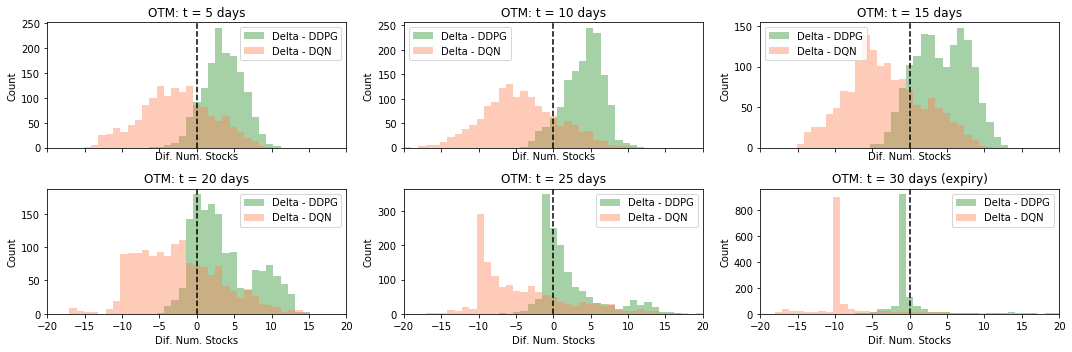

In [265]:
fig, axes = plt.subplots(2,3,sharex=True,sharey=False,figsize=[15,5])
axes = axes.ravel()

diff1_nS = d_nS - p_nS
diff2_nS = d_nS - q_nS

for idx_time, ax in zip([5, 10, 15, 20, 25, 30], axes):
    
    xs = diff1_nS[:, idx_time]
    df = pd.DataFrame()
    df['diffS'] = xs
    df['S'] = d_S[:, -1]
    xs = df[df['S'] < K]['diffS'].values
    ax.hist(xs, bins=41, range=(-20,20), alpha=0.4, label='Delta - DDPG', color='forestgreen')
    
    xs = diff2_nS[:, idx_time]
    df = pd.DataFrame()
    df['diffS'] = xs
    df['S'] = d_S[:, -1]
    xs = df[df['S'] < K]['diffS'].values
    ax.hist(xs, bins=41, range=(-20,20), alpha=0.4, label='Delta - DQN', color='coral')
    
    if idx_time < T:
        ax.set_title("OTM: t = {} days".format(idx_time))
    else:
        ax.set_title("OTM: t = {} days (expiry)".format(idx_time))
    ax.set_xlim(-20, 20)
    ax.set_xlabel('Dif. Num. Stocks')
    ax.set_ylabel('Count')
    ax.legend(frameon=True)
    ax.axvline(0, color='k', ls='--')

plt.tight_layout()
plt.show()

In [266]:
def plot_chg_nS_hist(nS, ax, ttl, color):
    chg_nS = np.diff(nS, axis=1)[5:, :]
    chg_nS = chg_nS.flatten()
    ax.hist(chg_nS, range=(-60, 60), bins=31, color=color, alpha=0.5)
    ax.axvline(0, ls='--', color='k')
    
    std = np.std(chg_nS, ddof=1)
    p1 = stats.scoreatpercentile(chg_nS,25)
    p2 = stats.scoreatpercentile(chg_nS,75)
    
    ax.set_title(ttl+'\nStdDev={0:.1f}, 25%Tile={1:.1f}, 75%Tile={2:.1f}'.format(std, p1, p2))
    ax.set_xlabel('Change of Num. Stocks Over Day')
    ax.set_ylabel('Count')

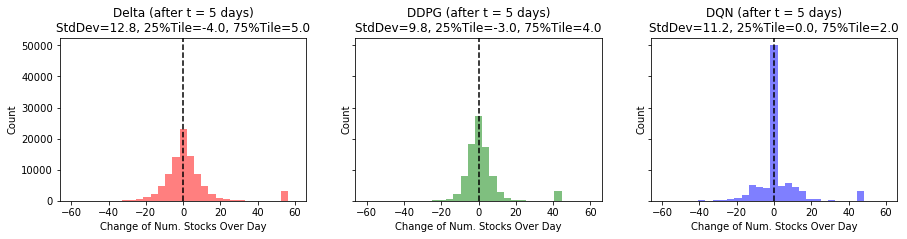

In [267]:
fig, axes = plt.subplots(1,3,sharex=True, sharey=True, figsize=[15,3])
plot_chg_nS_hist(d_nS, axes[0], 'Delta (after t = 5 days)', 'red')
plot_chg_nS_hist(p_nS, axes[1], 'DDPG (after t = 5 days)', 'green')
plot_chg_nS_hist(q_nS, axes[2], 'DQN (after t = 5 days)', 'blue')

### Risk of Portofolio (delta)

In [268]:
delta = p_hists3[:, :, 3]
d_risk = d_nS - delta
p_risk = p_nS - delta
q_risk = q_nS - delta

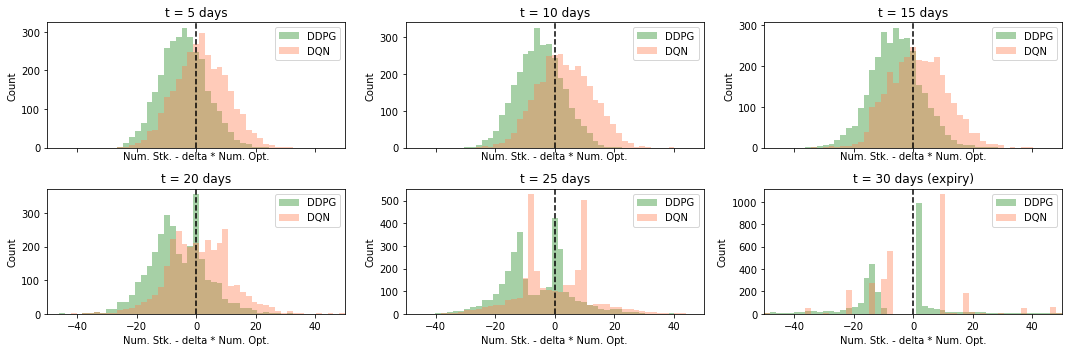

In [269]:
fig, axes = plt.subplots(2,3,sharex=True,sharey=False,figsize=[15,5])
axes = axes.ravel()

for idx_time, ax in zip([5, 10, 15, 20, 25, 30], axes):
    
    xs = p_risk[:, idx_time]
    ax.hist(xs, bins=51, range=(-50,50), alpha=0.4, label='DDPG', color='forestgreen')
    
    xs = q_risk[:, idx_time]
    ax.hist(xs, bins=51, range=(-50,50), alpha=0.4, label='DQN', color='coral')
    
    if idx_time < T:
        ax.set_title("t = {} days".format(idx_time))
    else:
        ax.set_title("t = {} days (expiry)".format(idx_time))
    ax.set_xlim(-50, 50)
    ax.set_xlabel('Num. Stk. - delta * Num. Opt.')
    ax.set_ylabel('Count')
    ax.legend(frameon=True)
    ax.axvline(0, color='k', ls='--')

plt.tight_layout()
plt.show()

In [270]:
delta = p_hists3[:, :, 3]
d_risk = d_nS - delta
p_risk = p_nS - delta
q_risk = q_nS - delta

d_risk = d_risk[:, :-1]
d_chg = np.diff(d_nS, n=1, axis=1)

p_risk = p_risk[:, :-1]
p_chg = np.diff(p_nS, n=1, axis=1)

q_risk = q_risk[:, :-1]
q_chg = np.diff(q_nS, n=1, axis=1)

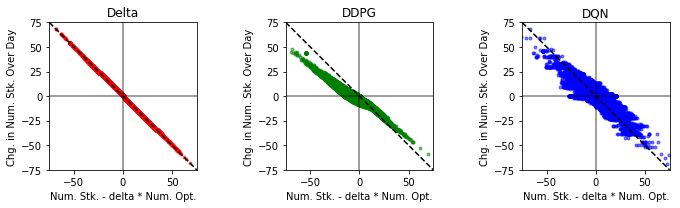

In [271]:
plt.figure(figsize=[10,3])
zs = np.linspace(-75, 75)
ws = np.linspace(75, -75)

ax = plt.subplot(131, aspect='equal')
xs = d_risk.flatten()
ys = d_chg.flatten()
ax.scatter(xs, ys, marker='.', c='r', alpha=0.5)
ax.plot(zs, ws, color='k', ls='--')
ax.axhline(0, color='k', alpha=0.5)
ax.axvline(0, color='k', alpha=0.5)
ax.set_xlim(-75,75)
ax.set_ylim(-75,75)
ax.set_title('Delta')
ax.set_xlabel('Num. Stk. - delta * Num. Opt.')
ax.set_ylabel('Chg. in Num. Stk. Over Day')

ax = plt.subplot(132, aspect='equal')
xs = p_risk.flatten()
ys = p_chg.flatten()
ax.scatter(xs, ys, marker='.', c='g', alpha=0.5)
ax.plot(zs, ws, color='k', ls='--')
ax.axhline(0, color='k', alpha=0.5)
ax.axvline(0, color='k', alpha=0.5)
ax.set_xlim(-75,75)
ax.set_ylim(-75,75)
ax.set_title('DDPG')
ax.set_xlabel('Num. Stk. - delta * Num. Opt.')
ax.set_ylabel('Chg. in Num. Stk. Over Day')

ax = plt.subplot(133, aspect='equal')
xs = q_risk.flatten()
ys = q_chg.flatten()
ax.scatter(xs, ys, marker='.', c='b', alpha=0.5)
ax.plot(zs, ws, color='k', ls='--')
ax.axhline(0, color='k', alpha=0.5)
ax.axvline(0, color='k', alpha=0.5)
ax.set_xlim(-75,75)
ax.set_ylim(-75,75)
ax.set_title('DQN')
ax.set_xlabel('Num. Stk. - delta * Num. Opt.')
ax.set_ylabel('Chg. in Num. Stk. Over Day')

plt.tight_layout()
plt.show()

In [292]:
delta = p_hists3[:, :, 3]
d_risk = d_nS - delta
p_risk = p_nS - delta
q_risk = q_nS - delta

d_risk = d_risk[:, :-1]
d_chg = np.diff(d_nS, n=1, axis=1)

p_risk = p_risk[:, :-1]
p_chg = np.diff(p_nS, n=1, axis=1)

q_risk = q_risk[:, :-1]
q_chg = np.diff(q_nS, n=1, axis=1)

def to_df(risk, chg):
    df = pd.DataFrame()
    df['t'] = d_t[:, :-1].flatten()
    df['S'] = d_S[:, :-1].flatten()
    df['risk'] = risk.flatten()
    df['chg'] = chg.flatten()
    return df

d_df = to_df(d_risk, d_chg)
p_df = to_df(p_risk, p_chg)
q_df = to_df(q_risk, q_chg)

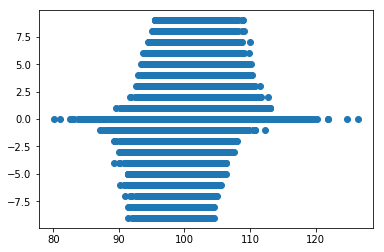

In [293]:
df = d_df[abs(d_df['chg']) < 10]
xs = df['S']
ys = df['chg']
plt.scatter(xs, ys)